Reddit is a social media platform that allows users to create "subreddits", which are communities usually centered around a single topic. The individuals in the subreddit are able to submit content in the form of text, links, or images, which are then upvoted or downvoted by the other members. 



Reddit was the center of the financial news world in early 2021, as members of the WallStreetBets subreddit coordinated to drive up the prices of stocks like Gamestop and AMC. The goal of the subreddit was to take advantage of large hedge funds that "shorted" stocks, or bet against them going down. The plan was to get the members of the WallStreetBets community, which has around 3 million members, to buy stock in companies that were shorted by the hedge fund owners. This drove the price up, forcing the hedge fund owners to buy back stock, which even further increased the price. Gamestop's stock price rose by as much as 1,800% in only a week, which was the result of the WallStreetBets community reluctance to sell and determiniation to "hold the line".

The WallStreetBets subreddit acted as the headquarters for coordinating and executing a massive market movement against wealthy hedge fund owners. By using Python's sentiment analysis libraries, we can get a better idea of what was being said and of the underlying emotions in the posts. 

# Importing and Cleaning Data

In [1]:
# Sentiment Libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import text2emotion as te
import spacy as sp
import nltk
nltk.download('stopwords')
nlp = sp.load('en_core_web_sm')

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Other
import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings
import datetime as dt

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickcarrolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickcarrolli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickcarrolli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickcarrolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('reddit_wsb.csv')

In [3]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [4]:
# Dropping columns
df.drop(['id', 'url', 'created'], inplace=True, axis=1)

# Setting timestamp column to DateTime and making it the inedx
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)


# Creating new date columns from the index 
df['month'] = df.index.month
df['day'] = df.index.day
df['minute'] = df.index.minute
df['hour'] = df.index.hour

df.isna().sum()

title            0
score            0
comms_num        0
body         15757
month            0
day              0
minute           0
hour             0
dtype: int64

In [5]:
# Drop NA rows and rows with duplicates
df.dropna(inplace=True)

df.drop_duplicates(subset='title', keep='first', inplace=True)
df.shape

(16783, 8)

In [6]:
def clean_text(data, column):
    # Remove text containing an @ (Twitter)
    data[column] = data[column].apply(lambda x : re.sub('@[^\s]+', '', x))
    
    # Remove text with links
    data[column] = data[column].apply(lambda x : re.sub(r'http\S+', '', x))
    
    # Remove special characters
    data[column] = data[column].apply(lambda x : re.sub(r'\s+[a-zA-Z]\s+', '', x))
    data[column] = data[column].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    
    # Remove whitespace
    data[column] = data[column].apply(lambda x:' '.join(re.findall(r'\w+', x)))
        
    return data

In [7]:
df = clean_text(df, 'title')
df = clean_text(df, 'body')

df.head()

,title,score,comms_num,body,month,day,minute,hour
timestamp,,,,,,,,
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading to gi...,1,28,30,21
2021-01-28 21:26:27,SHORT STOCK DOESN T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,1,28,26,21
2021-01-28 21:19:31,THIS IS THE MOMENT,405,178,Life isn t fair My mother always told me that ...,1,28,19,21
2021-01-28 21:18:25,We need to keep this movement going we all can...,222,70,believe right now is one of those rare opportu...,1,28,18,21
2021-01-28 21:17:10,Once you re done with GME AG and SLV the gentl...,0,16,You guys are champs GME who would have thought...,1,28,17,21


# Feature Engineering

In [8]:
# Get word counts for title and body
title_count = df['title'].str.split().str.len()
body_count = df['body'].str.split().str.len()

df['title_wc'] = title_count.values
df['body_wc'] = body_count.values

df.head()

,title,score,comms_num,body,month,day,minute,hour,title_wc,body_wc
timestamp,,,,,,,,,,
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading to gi...,1,28,30,21,3,214
2021-01-28 21:26:27,SHORT STOCK DOESN T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,1,28,26,21,8,125
2021-01-28 21:19:31,THIS IS THE MOMENT,405,178,Life isn t fair My mother always told me that ...,1,28,19,21,4,339
2021-01-28 21:18:25,We need to keep this movement going we all can...,222,70,believe right now is one of those rare opportu...,1,28,18,21,12,127
2021-01-28 21:17:10,Once you re done with GME AG and SLV the gentl...,0,16,You guys are champs GME who would have thought...,1,28,17,21,18,259


In [9]:
sia = SentimentIntensityAnalyzer()

df['title_sentiment'] = df['title'].apply(lambda x : sia.polarity_scores(x))
df['title_pos'] = df['title_sentiment'].apply(lambda x : x['pos'])
df['title_neg'] = df['title_sentiment'].apply(lambda x : x['neg'])

df['body_sentiment'] = df['body'].apply(lambda x : sia.polarity_scores(x))
df['body_pos'] = df['body_sentiment'].apply(lambda x : x['pos'])
df['body_neg'] = df['body_sentiment'].apply(lambda x : x['neg'])


df.drop(['title_sentiment', 'body_sentiment'], inplace=True, axis=1)

df.head()

,title,score,comms_num,body,month,day,minute,hour,title_wc,body_wc,title_pos,title_neg,body_pos,body_neg
timestamp,,,,,,,,,,,,,,
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading to gi...,1,28,30,21,3,214,0.0,0.0,0.057,0.061
2021-01-28 21:26:27,SHORT STOCK DOESN T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,1,28,26,21,8,125,0.0,0.0,0.031,0.094
2021-01-28 21:19:31,THIS IS THE MOMENT,405,178,Life isn t fair My mother always told me that ...,1,28,19,21,4,339,0.0,0.0,0.061,0.171
2021-01-28 21:18:25,We need to keep this movement going we all can...,222,70,believe right now is one of those rare opportu...,1,28,18,21,12,127,0.0,0.0,0.148,0.084
2021-01-28 21:17:10,Once you re done with GME AG and SLV the gentl...,0,16,You guys are champs GME who would have thought...,1,28,17,21,18,259,0.0,0.0,0.122,0.046


# Data Analysis

### Frequently Mentioned Organizations

In [10]:
def get_organizations(sentence):
    for i in nlp(sentence).ents:
        if i.label_ == 'ORG':
            return i[0]

In [11]:
# Get the number of organizations mentioned
df['Num_Org'] = df['title'].apply(lambda x : len([t for t in nlp(x).ents if t.label_ == 'ORG']))

# Create new dataframe, and keep only rows where there is at least one organization
org = df[df['Num_Org'] != 0]

# Get the first organization mentioned
org['Org_Name'] = org['title'].apply(lambda x : get_organizations(x))

org.head()

,title,score,comms_num,body,month,day,minute,hour,title_wc,body_wc,title_pos,title_neg,body_pos,body_neg,Num_Org,Org_Name
timestamp,,,,,,,,,,,,,,,,
2021-01-28 21:17:10,Once you re done with GME AG and SLV the gentl...,0,16,You guys are champs GME who would have thought...,1,28,17,21,18,259,0.000,0.0,0.122,0.046,2,GME
2021-01-28 21:15:58,GME price has nothing to do with fundamentals ...,382,61,Firstly all of you diamond hands and smooth br...,1,28,15,21,15,911,0.000,0.0,0.135,0.103,1,GME
2021-01-28 20:18:32,My brokerage wants to force close my GME calls,560,215,My brokerage called me and asked me to close m...,1,28,18,20,9,236,0.000,0.0,0.078,0.054,1,GME
2021-01-28 19:57:53,The real price for GME is infinity but at that...,235,120,Lets imagine GME has gone to 50 000 The market...,1,28,57,19,16,203,0.135,0.0,0.057,0.162,1,GME
2021-01-28 19:54:44,OG s Prepare to show the world who we are,526,98,The time has come for us to show the world who...,1,28,54,19,10,280,0.000,0.0,0.054,0.052,1,OG


In [12]:
org['Org_Name'] = org['Org_Name'].astype(str)

# Get count of organizations
org_count = org.groupby('Org_Name').count()['score']

# Get mean sentiment by orginzation
org_means = org.groupby('Org_Name').mean()

# Add the count of each organization to the dataframe
org_means['Count'] = org_count

# Sort by the most mentioned, and keep first 25
org_means = org_means.sort_values('Count', ascending=False).head(25)
org_count = org_count.sort_values(ascending=False)[:25]

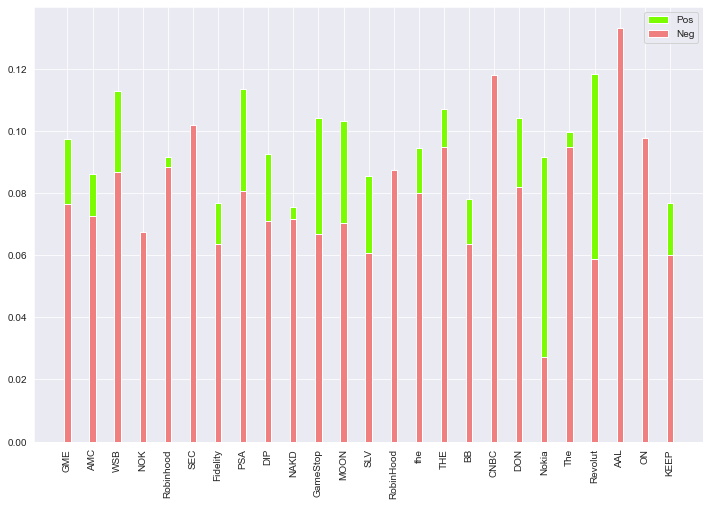

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
ax.bar(org_means.index, org_means['body_pos'], width = .25, label = 'Pos', color = 'lawngreen')
ax.bar(org_means.index, org_means['body_neg'], width = .25, label = 'Neg', color = 'lightcoral')
plt.xticks(rotation = 90)
plt.legend()

plt.show()

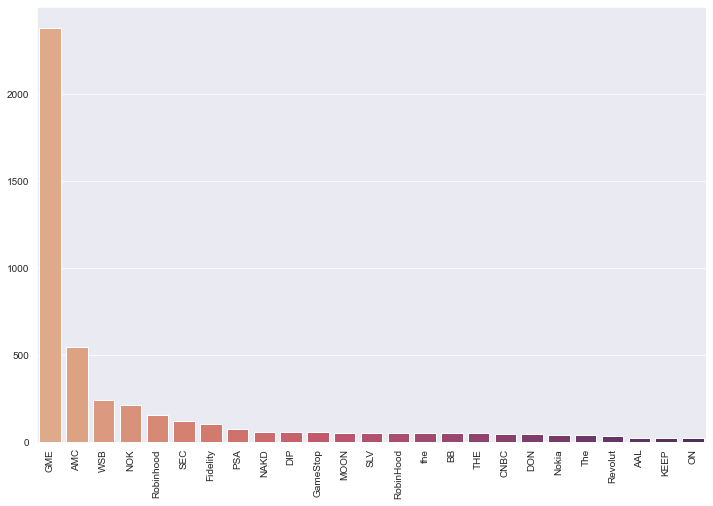

In [14]:
fig = plt.figure(figsize = (12,8))
sns.barplot(x = org_count.index, y = org_count.values, palette = 'flare')
plt.xticks(rotation = 90)

plt.xlabel('')
plt.show()

### Frequently Used Words

In [15]:
def most_common_words(column):
    stop_words = set(stopwords.words('english'))
    word_list = []
    
    # Split the sentence and add words to the list
    for row in column.str.lower():
        for word in row.split(' '):
            if word not in stop_words:
                word_list.append(word)
        
    # Remove common English words
    filtered = [w for w in word_list if not w in stop_words]
    
    dct = Counter(filtered).most_common(25)
    
    return pd.DataFrame(dct, columns = ['Word', 'Count'])


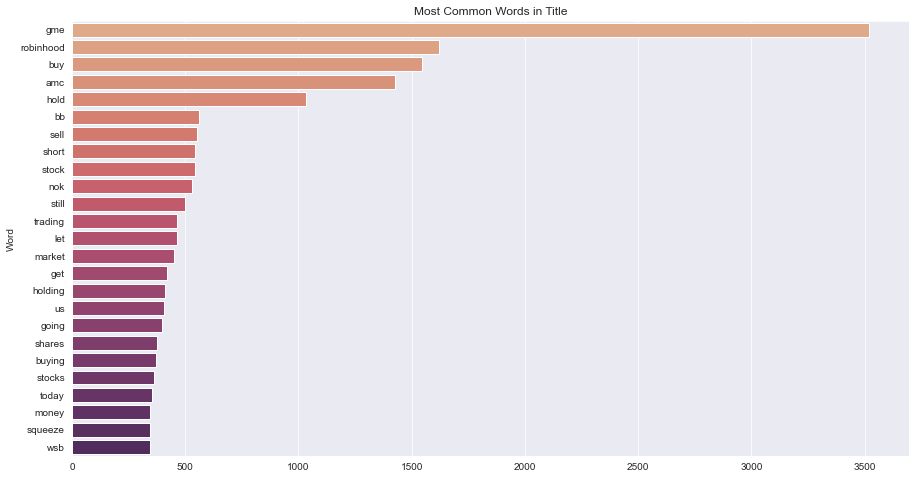

In [16]:
title_mc = most_common_words(df['title'])

fig = plt.figure(figsize = (15,8))

sns.barplot(x = 'Count', y = 'Word', data = title_mc, palette = 'flare')

plt.xlabel('')
plt.title('Most Common Words in Title')


plt.show()

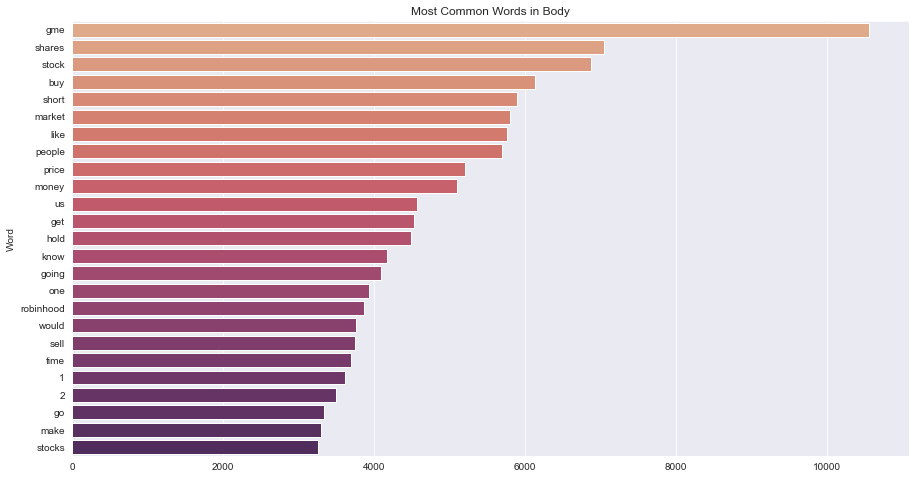

In [17]:
body_mc = most_common_words(df['body'])

fig = plt.figure(figsize = (15,8))

sns.barplot(x = 'Count', y = 'Word', data = body_mc, palette = 'flare')

plt.xlabel('')
plt.title('Most Common Words in Body')


plt.show()

### Distribution of Word Counts

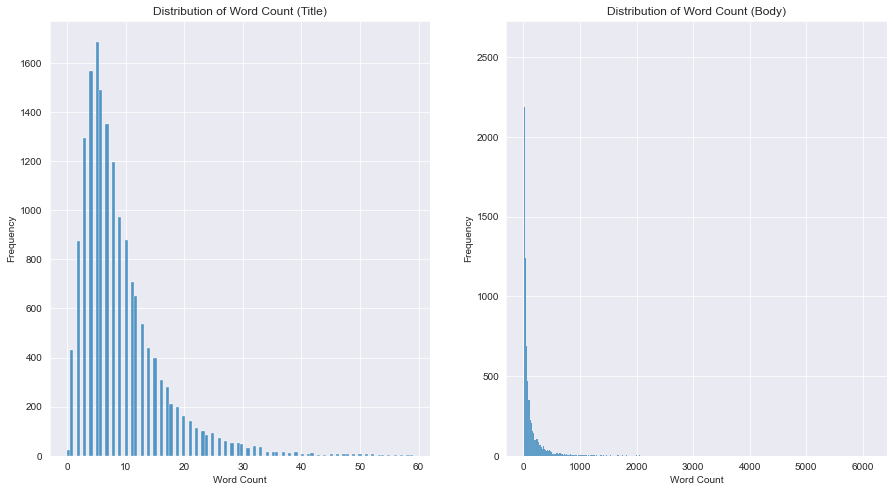

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))

sns.histplot(x='title_wc', data=df, ax = ax1)

sns.histplot(x='body_wc', data = df[df['body_wc'] != 0], ax = ax2)


ax1.set_xlabel('Word Count')
ax2.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')

ax1.set_title('Distribution of Word Count (Title)')
ax2.set_title('Distribution of Word Count (Body)')


plt.show()

### Number of Posts and Comments / Day

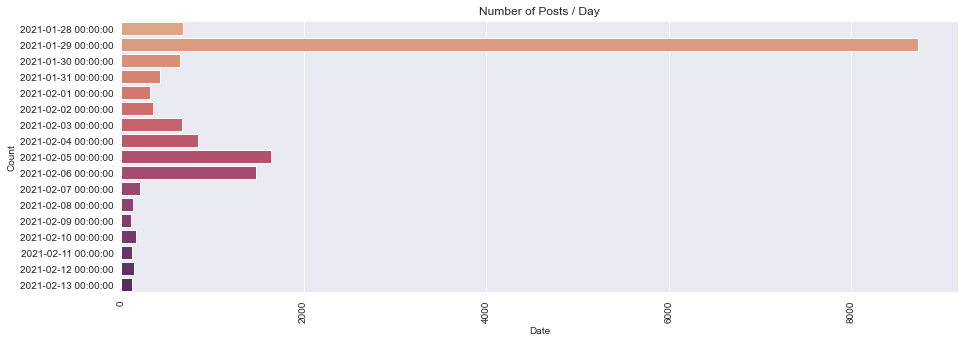

In [19]:
fig = plt.figure(figsize = (15,5))
fig.tight_layout()
daily_posts = df.groupby(pd.Grouper(freq='D')).count()

sns.barplot(x = 'title', y = daily_posts.index, data = daily_posts, palette = 'flare')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Posts / Day')
plt.xticks(rotation = 90)
fig.savefig('num_posts_day.png')

plt.show()

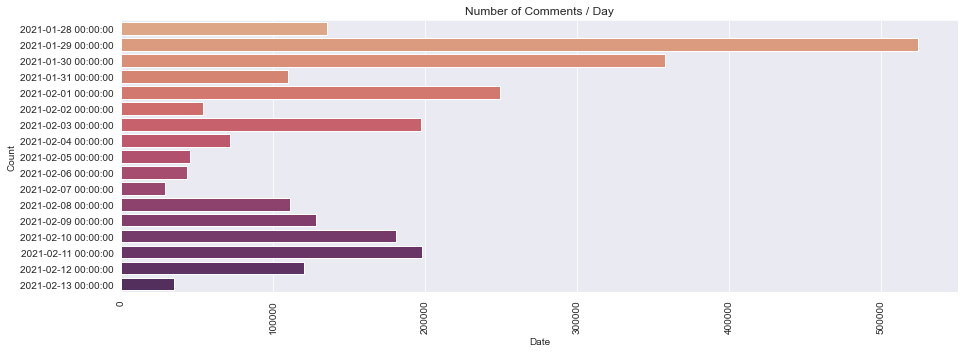

In [20]:
fig = plt.figure(figsize = (15,5))
daily_comments = df.groupby(pd.Grouper(freq='D')).sum()
fig.tight_layout()

sns.barplot(x = 'comms_num', y = daily_comments.index, data = daily_comments, palette = 'flare')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Comments / Day')
plt.xticks(rotation = 90)
fig.savefig('num_comments_day.png')

plt.show()

### What Happened on January 29?

January 29, 2021 was a day of extreme volatility on the stock market, and was the day WallStreetBets was most active.

[A total of 19.58 billion shares were traded on Thursday, higher than the last 20-session average of 14.86 billion.](https://finance.yahoo.com/news/stock-market-news-jan-29-143602336.html#:~:text=A%20total%20of%2019.58%20billion,1%20ratio%20favored%20advancing%20issues.)

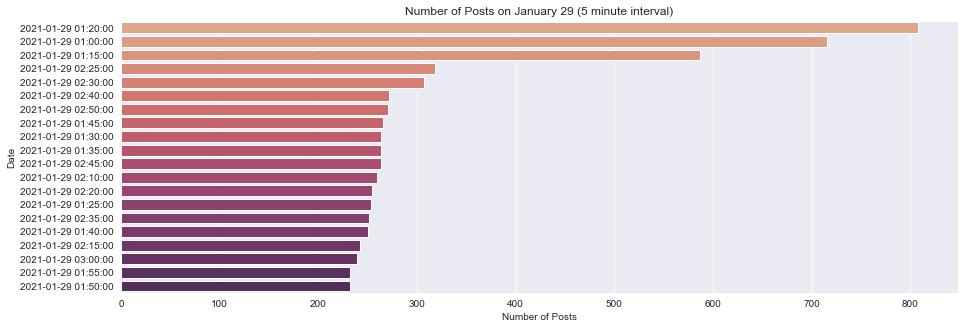

In [21]:
jan29 = df[(df['month'] == 1) & (df['day'] == 29)]

jan29_min = jan29.groupby(pd.Grouper(freq='5Min')).count()

jan29_min = jan29_min.sort_values('title', ascending=False).head(20)

fig = plt.figure(figsize = (15,5))

sns.barplot(x = 'title', y = jan29_min.index, data = jan29_min, palette = 'flare')

plt.xlabel('Number of Posts')
plt.ylabel('Date')
plt.title('Number of Posts on January 29 (5 minute interval)')

plt.show()

In [22]:
jan29 = jan29[(jan29['hour'] >= 1 )& (jan29['hour'] <= 3)]

title_tokens = nlp(''.join(str(jan29.title.tolist())))
items = [x.text for x in title_tokens.ents]

stop_words = set(stopwords.words('english'))

filtered = [w for w in items if (w not in stop_words and w.isalpha())]
    
dct = Counter(filtered).most_common(25)
    
most_common = pd.DataFrame(dct, columns = ['Word', 'Count'])

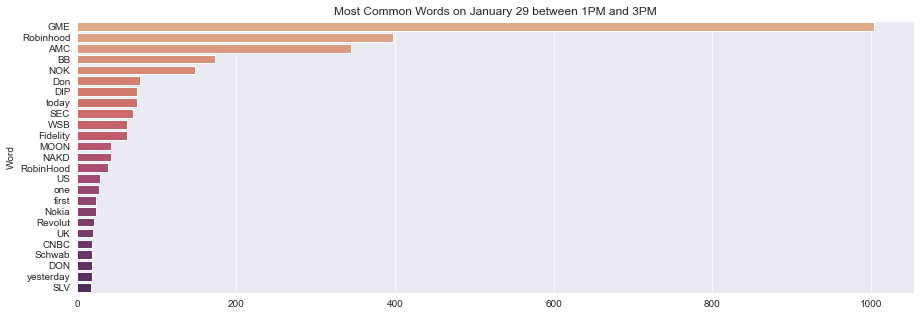

In [23]:
fig = plt.figure(figsize = (15,5))

sns.barplot(x = 'Count', y = 'Word', data = most_common, palette = 'flare')

plt.xlabel('')
plt.title('Most Common Words on January 29 between 1PM and 3PM')


plt.show()

### Distribution of Sentiments (20 minute interval)

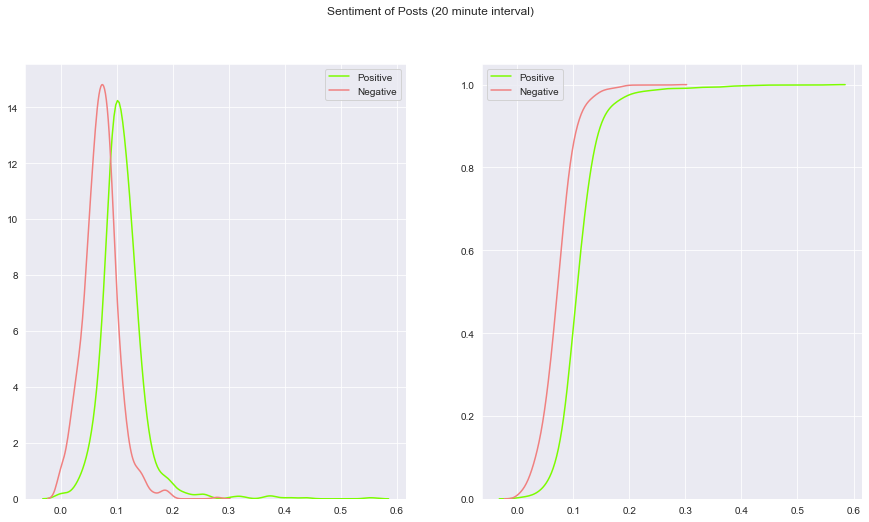

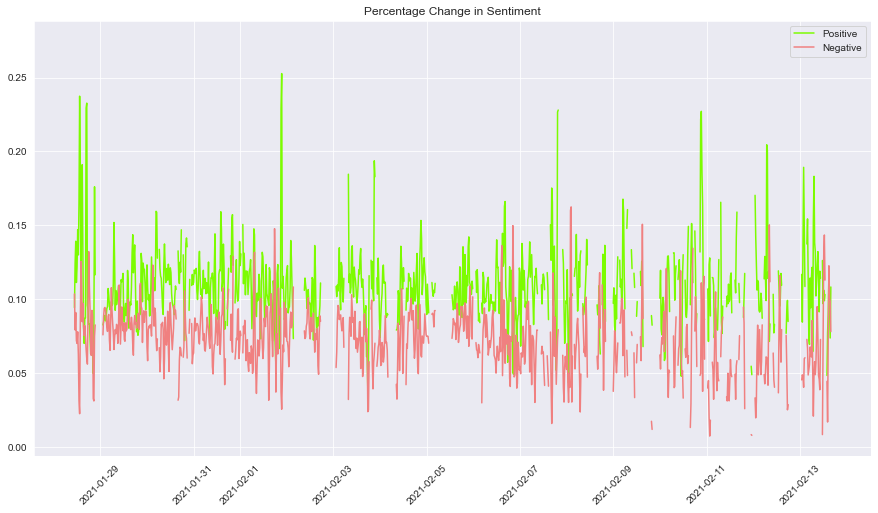

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))
sent_by_min = df.groupby(pd.Grouper(freq='20Min')).mean()

sns.kdeplot(x = 'body_pos', data = sent_by_min, label = 'Positive', ax = ax1, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_min, label = 'Negative', ax = ax1, color = 'lightcoral')

sns.kdeplot(x = 'body_pos', data = sent_by_min, cumulative = True, label = 'Positive', ax = ax2, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_min, cumulative = True, label = 'Negative', ax = ax2, color = 'lightcoral')

ax1.legend()
ax2.legend()

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.suptitle('Sentiment of Posts (20 minute interval)')


min_pct_change = sent_by_min.rolling(window=2).mean()
fig = plt.figure(figsize = (15,8))
fig.tight_layout()

sns.lineplot(x = min_pct_change.index, y = 'body_pos', data = min_pct_change, label = 'Positive', color = 'lawngreen')
sns.lineplot(x = min_pct_change.index, y = 'body_neg', data = min_pct_change, label = 'Negative', color = 'lightcoral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 45)


plt.show()

### Distribution of Sentiments (Hourly interval)

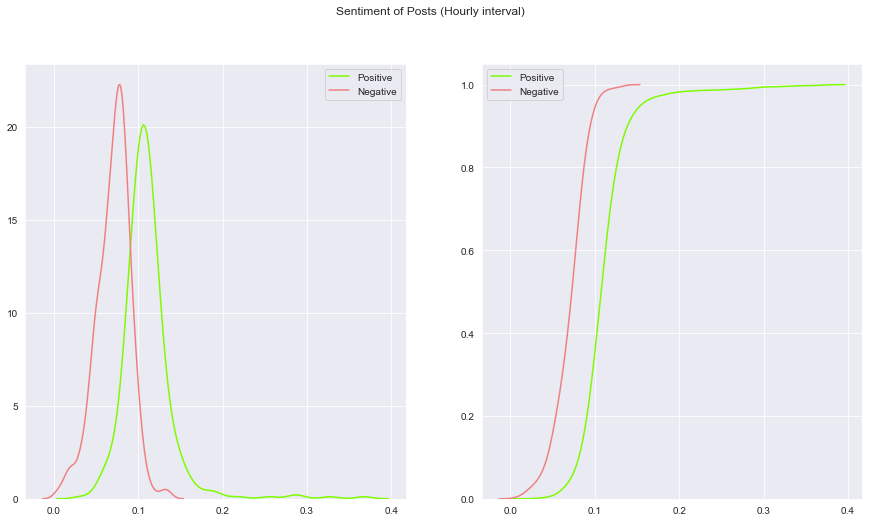

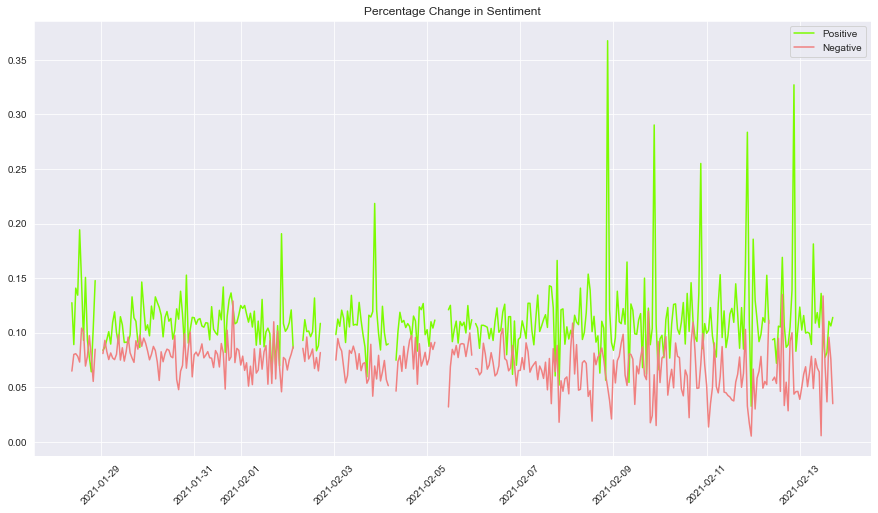

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))

sent_by_hour = df.groupby(pd.Grouper(freq='H')).mean()

sns.kdeplot(x = 'body_pos', data = sent_by_hour, label = 'Positive', ax = ax1, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_hour, label = 'Negative', ax = ax1, color = 'lightcoral')

sns.kdeplot(x = 'body_pos', data = sent_by_hour, cumulative = True, label = 'Positive', ax = ax2, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_hour, cumulative = True, label = 'Negative', ax = ax2, color = 'lightcoral')

ax1.legend()
ax2.legend()

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.suptitle('Sentiment of Posts (Hourly interval)')


hour_pct_change = sent_by_hour.rolling(window=1).mean()
fig = plt.figure(figsize = (15,8))
fig.tight_layout()

sns.lineplot(x = hour_pct_change.index, y = 'body_pos', data = hour_pct_change, label = 'Positive', color = 'lawngreen')
sns.lineplot(x = hour_pct_change.index, y = 'body_neg', data = hour_pct_change, label = 'Negative', color = 'lightcoral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 45)

plt.show()

### Distribution of Sentiments (Daily interval)

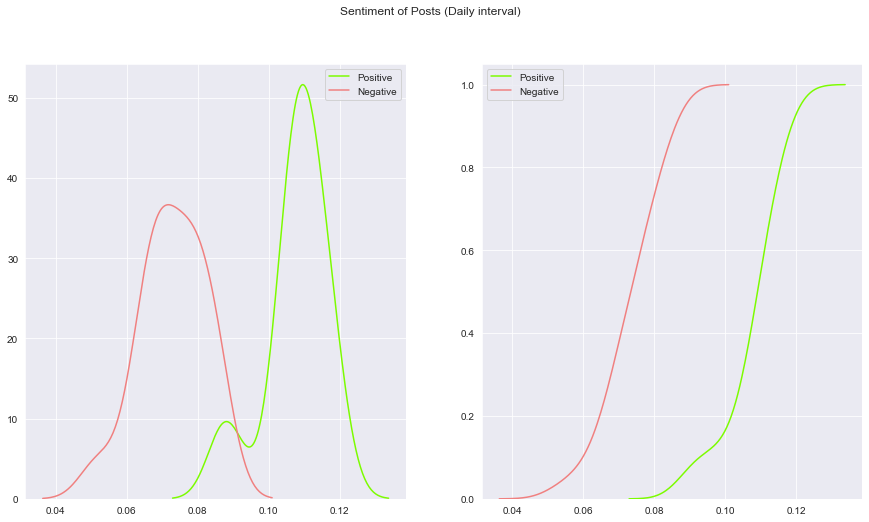

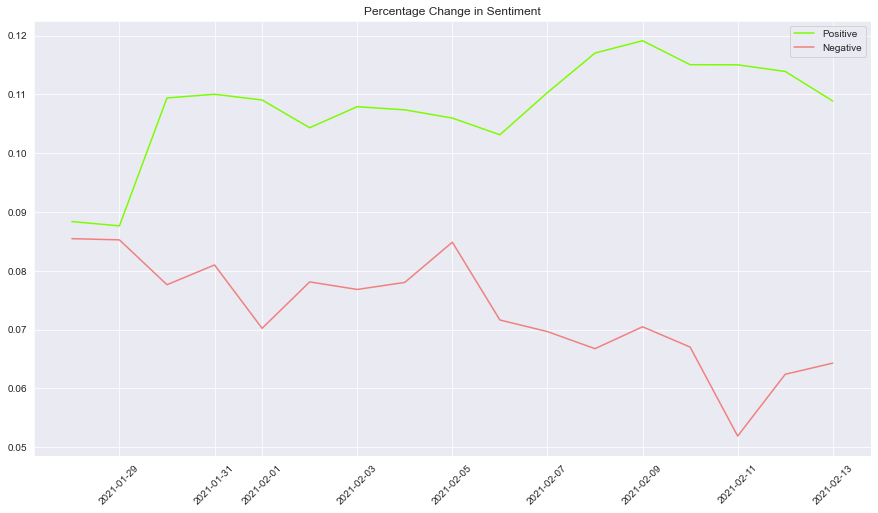

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))

sent_by_day = df.groupby(pd.Grouper(freq='D')).mean()

sns.kdeplot(x = 'body_pos', data = sent_by_day, label = 'Positive', ax = ax1, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_day, label = 'Negative', ax = ax1, color = 'lightcoral')

sns.kdeplot(x = 'body_pos', data = sent_by_day, cumulative = True, label = 'Positive', ax = ax2, color = 'lawngreen')
sns.kdeplot(x = 'body_neg', data = sent_by_day, cumulative = True, label = 'Negative', ax = ax2, color = 'lightcoral')

ax1.legend()
ax2.legend()

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.suptitle('Sentiment of Posts (Daily interval)')


day_pct_change = sent_by_day.rolling(window=1).mean()
fig = plt.figure(figsize = (15,8))
fig.tight_layout()

sns.lineplot(x = day_pct_change.index, y = 'body_pos', data = day_pct_change, label = 'Positive', color = 'lawngreen')
sns.lineplot(x = day_pct_change.index, y = 'body_neg', data = day_pct_change, label = 'Negative', color = 'lightcoral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 45)

plt.show()

### Correlation Matrix

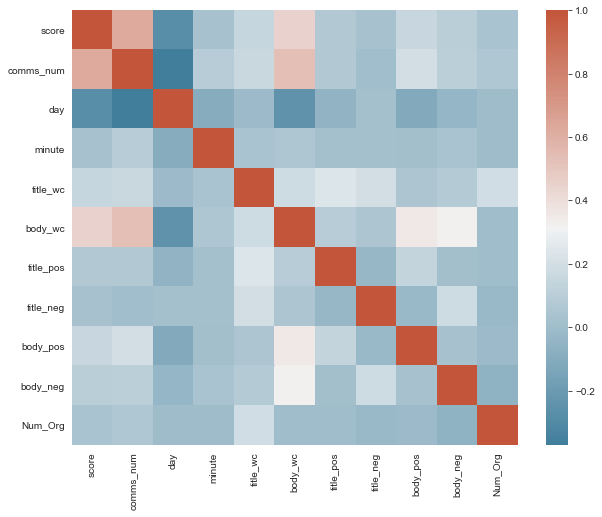

In [27]:
filtered = df[['score', 'comms_num', 'day', 'minute', 'title_wc', 'body_wc', 'title_pos', 'title_neg',
               'body_pos', 'body_neg', 'Num_Org']]

corr = filtered.corr('spearman')

fig = plt.figure(figsize = (10,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

plt.show()

### Emotion of Posts

In [28]:
# text2emotion takes too long with the full dataframe, so I will filter by only using posts that have a score of above 15
emotions = df[df['score'] >= 15]

In [29]:
def get_emotions(data):

    emotions = []
    for text in data['title']:
        emotions.append(te.get_emotion(str(text)))
    
    emotion_df = pd.DataFrame.from_dict(emotions)
    
    data['Happy'] = emotion_df['Happy'].values
    data['Angry'] = emotion_df['Angry'].values
    data['Sad'] = emotion_df['Sad'].values
    data['Fear'] = emotion_df['Fear'].values
    
    return data

In [30]:
emotions = get_emotions(emotions)

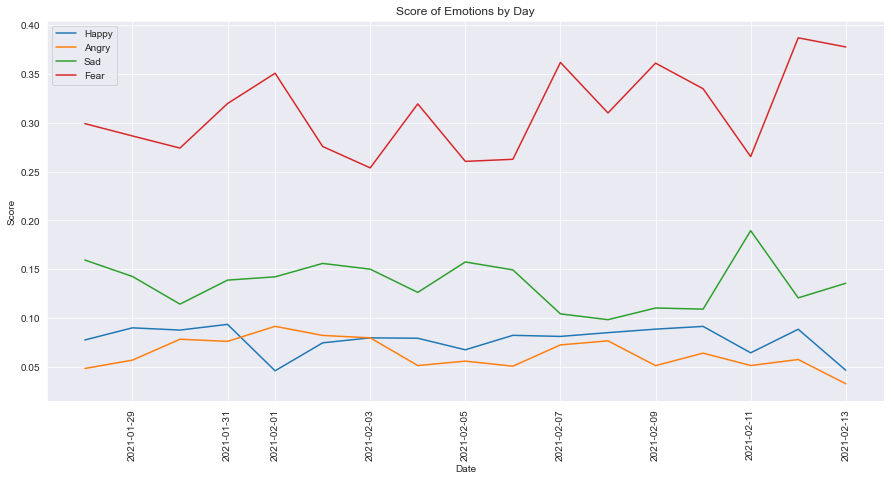

In [31]:
emotions_by_day = emotions.groupby(pd.Grouper(freq='D')).mean()

fig = plt.figure(figsize = (15,7))
sns.lineplot(x = emotions_by_day.index, y = 'Happy', data = emotions_by_day, label = 'Happy')
sns.lineplot(x = emotions_by_day.index, y = 'Angry', data = emotions_by_day, label = 'Angry')
sns.lineplot(x = emotions_by_day.index, y = 'Sad', data = emotions_by_day, label = 'Sad')
sns.lineplot(x = emotions_by_day.index, y = 'Fear', data = emotions_by_day, label = 'Fear')

plt.xticks(rotation = 90)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Score of Emotions by Day')
plt.show()